<a href="https://colab.research.google.com/github/act-moises/diplomado/blob/main/Clusterizaci%C3%B3n_de_alumnado_para_optimizar_la_asignaci%C3%B3n_de_materias_optativas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
library(ggplot2)
library(dplyr)
library(tidyverse)
library(tidyr)
library(stats)

In [101]:
# cargar información ya limpia
data <- read.csv('Data_limpia.csv')
View(data)

Individuo,Orden.de.preferencia,Clave
<int>,<int>,<int>
1,5,2030
1,4,2031
1,3,2049
1,2,2046
1,1,2047
2,5,2035
2,4,2056
2,3,2036
2,2,2040


In [102]:
#Como la columna de clase es un identificador la volvemos a tipo factor
data$Clave <- as.factor(data$Clave)
names(data)

[1] "Individuo"            "Orden.de.preferencia" "Clave"

In [103]:
#Vemos el numero de solicitudes por alumno
data %>%
  group_by(Individuo) %>%
  summarise(n=n()) %>%
  group_by(n) %>%
  summarise(min = min(n),max=max(n))
#No todos los alumnos pidieron 5 mataterias

n,min,max
<int>,<int>,<int>
2,2,2
3,3,3
4,4,4
5,5,5


In [104]:
#Vemos cuales son las clases distitnas que existen
clases <- data$Clave %>%
  unique() %>%
  sort()

In [105]:
# Ahora creamos el vector que usaremos para las metricas
n_clases <- clases %>%
  length()

In [106]:
#Ahora contamos el número de alumnos
n_alumnos <- data$Individuo %>%
  unique() %>%
  length()


In [107]:
#Creamos dataframe donde almacenaremos la información de los alumnos
data_transformada <- matrix(0,
                            nrow = n_alumnos,
                            ncol = n_clases) %>%
  data.frame()

In [108]:
#Renombramos las columnas de este df
names(data_transformada) <- clases


In [109]:
#Ahora asignamos a cada preferencia a cada alumno
matriz_preferencias <- data %>%
  pivot_wider(names_from = 'Clave',values_from = 'Orden.de.preferencia',values_fill = 0)
#View(matriz_preferencias)

In [110]:
#Eliminamos la primer columna
matriz_preferencias <- matriz_preferencias[,-1] %>% data.frame()
#View(matriz_preferencias)

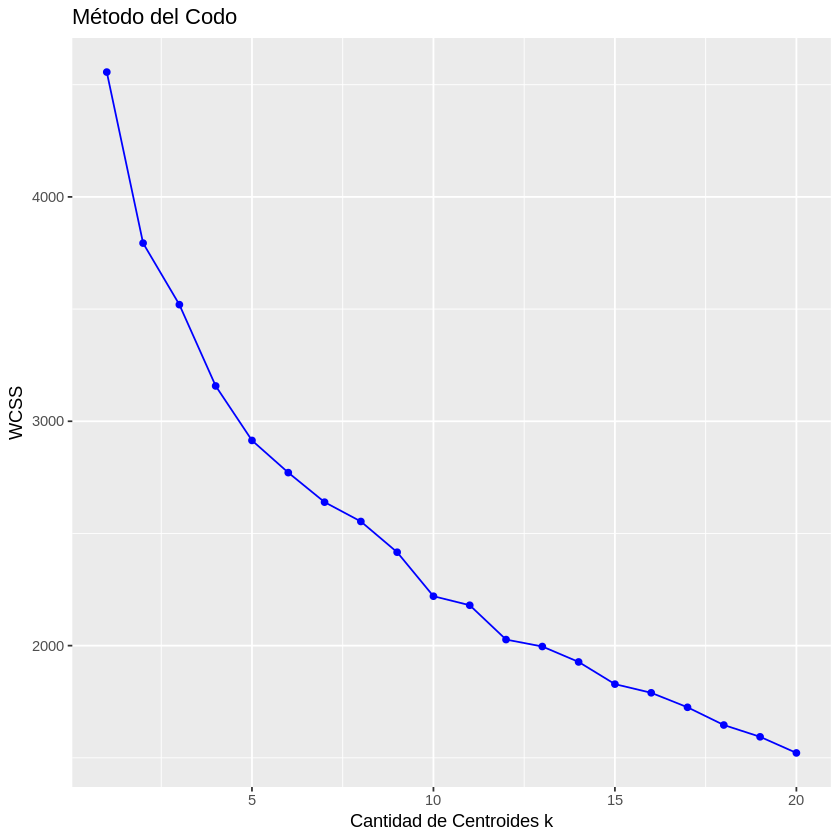

In [111]:
#Vemos cuál es el mejor numero de clusters

wcss <- vector()
for(i in 1:20){
  wcss[i] <- sum(kmeans(matriz_preferencias, i)$withinss)
}
ggplot() + geom_point(aes(x = 1:20, y = wcss), color = 'blue') +
  geom_line(aes(x = 1:20, y = wcss), color = 'blue') +
  ggtitle("Método del Codo") +
  xlab('Cantidad de Centroides k') +
  ylab('WCSS')

Parece que es 5 el mejor número de clusters.

In [112]:
n_clusters <- 5

#Aplicamos k-means a vectores
set.seed(123)
clusters_kmeans <- kmeans(
  matriz_preferencias,
  n_clusters,
  iter.max = 100,
  nstart = 5)

In [113]:
#Añadimos cluster a matriz de preferencias
matriz_preferencias$cluster <- clusters_kmeans$cluster

#Añadimos columna identificador
matriz_preferencias$alumno <- 1:n_alumnos

#write.csv(matriz_preferencias,file = 'cluster_5.csv')
#Mostramos tamanio de cada cluster / grupo
matriz_preferencias %>%
  group_by(cluster) %>%
  summarise(tamanio = n()) %>%
  View()

cluster,tamanio
<int>,<int>
1,36
2,16
3,35
4,24
5,13


In [114]:
#Creamos una lista con los grupos
grupos <- list()

for(i in 1:n_clusters){
  grupos[[i]] <- matriz_preferencias %>%
    filter(cluster == i)
}


In [115]:
#Lista que contendrá la información final
lista_final = list()



for(i in 1:n_clusters){
  #Primero ordenamos las columnas del cluster

  #Vemos cuanto suma cada columna
  suma_columnas_i <- grupos[[i]] %>%
    colSums()

  #Ordenamos las columnas de acuerso a cuanto suman
  columnas_ordenadas_i <- suma_columnas_i[order(suma_columnas_i,decreasing=T)] %>%
    names()

  #Seleccionamos las columnas del cluster, pero ordenadas de acuerdo a la suma
  materias_grupo <- grupos[[i]][,columnas_ordenadas_i] %>%
    select(-alumno,-cluster) %>%
    colnames()

  #Seleccionamos las 5 materias que tienen mas solicitudes
  materias_grupo_i <- materias_grupo[1:5]

  lista_final[[i]] <- grupos[[i]][,materias_grupo_i]
  lista_final[[i]]$alumno <- grupos[[i]]$alumno
}



In [116]:
#Como este formato favorece la existencia de alumnos que solo tendrán la materia
# que mas les importaba, se usará otra técnica
grupos_auxiliar <- grupos
lista_final_2 <- list()


In [117]:
for(k in 1:n_clusters){
  data_solicitudes <- grupos_auxiliar[[k]] %>%
    select(-cluster,-alumno)

  for(i in 1:nrow(grupos_auxiliar[[k]])){
    #Cambiamos a uno para cualquier materia solicitada
      data_solicitudes[i,]<- ifelse(data_solicitudes[i,]==0,0,1)
  }
  data_solicitudes

  #Repetimos análisis de asignación de acuerdo a suma de columnas
  suma_columnas <- data_solicitudes %>% colSums()

  columnas_ordenadas <- suma_columnas[order(suma_columnas,decreasing=T)] %>%
    names()

  materias_seleccionadas <- data_solicitudes[,columnas_ordenadas] %>% colnames()
  lista_final_2[[k]] <- data_solicitudes[,materias_seleccionadas[1:5]]
  lista_final_2[[k]]$alumno <- grupos_auxiliar[[k]]$alumno

}
lista_final_2[[5]]


X2049,X2039,X2043,X2032,X2037,alumno
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0,0,0,0,1
1,0,1,0,0,9
1,1,1,0,0,42
1,1,1,0,0,44
1,1,0,1,1,69
1,1,0,1,1,74
1,1,0,1,1,81
1,1,0,1,0,89
1,0,0,1,1,96


In [122]:
materias_total <- c()

for(i in 1:n_clusters){
  cat('Materias del cluster ',i,':\n')
lista_final_2[[i]] %>% colnames()
materias_total <- c(materias_total,lista_final_2[[i]] %>% colnames())
lista_final_2[[i]] %>% colnames() %>% print
}

materias_total[!materias_total %in% c("alumno")] %>% table() %>% sort(decreasing = T)


Materias del cluster  1 :
[1] "X2032"  "X2039"  "X2037"  "X2041"  "X2031"  "alumno"
Materias del cluster  2 :
[1] "X2046"  "X2039"  "X2044"  "X2033"  "X2034"  "alumno"
Materias del cluster  3 :
[1] "X2033"  "X2049"  "X2039"  "X2046"  "X2043"  "alumno"
Materias del cluster  4 :
[1] "X2048"  "X2039"  "X2041"  "X2032"  "X2031"  "alumno"
Materias del cluster  5 :
[1] "X2049"  "X2039"  "X2043"  "X2032"  "X2037"  "alumno"


.
X2039 X2032 X2031 X2033 X2037 X2041 X2043 X2046 X2049 X2034 X2044 X2048 
    5     3     2     2     2     2     2     2     2     1     1     1 